## Descrição do problema

Nós trabalhamos em uma empresa de telecomunicações e um dos problemas da empresa é a alta taxa de churn. Para resolver isso, solicitamos uma base de dados com informações de diversos clientes anteriores para construir uma solução utilizando Machine Learning e prever se um futuro cliente irá dar churn ou não. 

## Informações do dataset:

- <strong>customerID</strong>: Código de identificação único do cliente
- <strong>gender</strong>: Gênero do cliente (Male ou Female)
- <strong>SeniorCitizen</strong>: Idoso ou não (1 ou 0)
- <strong>Partner</strong>: Possui um parceiro(a) (Yes ou No)
- <strong>tenure</strong>: Número de meses que o cliente ficou com a companhia
- <strong>PhoneService</strong>: Possui serviço de telefone (Yes ou No)
- <strong>MultipleLines</strong>: Possui múltiplas linhas de telefone (No phone service, No ou Yes)
- <strong>InternetService</strong>: Serviço de internet (DSL, Fiber optic, No)
- <strong>OnlineSecurity</strong>: Serviço de segurança online (No, Yes ou No internet service)
- <strong>OnlineBackup</strong>: Serviço de backup online (No, Yes ou No internet service)
- <strong>DeviceProtection</strong>: Proteção do dispositivo (No, Yes ou No internet service)
- <strong>TechSupport</strong>: Assistência técnica (No, Yes ou No internet service)
- <strong>StreamingTV</strong>: Possui serviço de streaming (No, Yes ou No internet service)
- <strong>StreamingMovies</strong>: Possui serviço de filmes em streaming (No, Yes ou No internet service)
- <strong>Contract</strong>: Tipo de contrato (Month-to-month, One year ou Two year)
- <strong>PaperlessBilling</strong>: Cobrança de conta sem papel (Yes ou No)
- <strong>PaymentMethod</strong>: Método de pagamento (Electronic check, Mailed check, Bank transfer ou Credit card)
- <strong>MonthlyCharges</strong>: Recarregamento mensal
- <strong>TotalCharges</strong>: Recarregamento total
- <strong>churn</strong>: Cliente deixou a companhia (churn) (Yes ou No)

# Importando bibliotecas e dataframe

In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import chdir
from warnings import filterwarnings
from math import floor

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from skopt import gp_minimize

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

chdir(r"C:\Users\Anwar\Desktop\Projects Jupyter\datasets\TELECOM Churn Prediction")
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.options.plotting.backend = "plotly"
colors = ['royalblue','midnightblue']

In [2]:
# Carregando dataframe
df = pd.read_csv("TELECOM_Churn_Prediction.csv", encoding = "cp1252", low_memory = False)

## Funções que utilizaremos

In [3]:
# Função para fazer o pré processamento dos dados
def preprocessor(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, scaler) -> (pd.DataFrame, pd.DataFrame):
    
    # Preenchendo missing
    num_imputer = SimpleImputer(strategy = 'median')
    cat_imputer = SimpleImputer(strategy = 'most_frequent')
    aux_num_train = pd.DataFrame(num_imputer.fit_transform(X_train[numerical_features]), columns = numerical_features)
    aux_cat_train = pd.DataFrame(cat_imputer.fit_transform(X_train[categorical_features]), columns = categorical_features)    
    aux_num_test = pd.DataFrame(num_imputer.transform(X_test[numerical_features]), columns = numerical_features)
    aux_cat_test = pd.DataFrame(cat_imputer.transform(X_test[categorical_features]), columns = categorical_features)
    X_train = pd.concat((aux_num_train, aux_cat_train), axis = 1)
    X_test = pd.concat((aux_num_test, aux_cat_test), axis = 1)
    
    # Encoding
    y_train = y_train.reset_index()["Churn"]
    cat_train = pd.DataFrame(cat_transformer.fit_transform(X_train, y_train), columns = np.concatenate((categorical_features_binary, categorical_features_non_binary)))
    cat_test = pd.DataFrame(cat_transformer.transform(X_test), columns = np.concatenate((categorical_features_binary, categorical_features_non_binary)))
    X_train = pd.concat((X_train[numerical_features], cat_train), axis = 1)
    X_test = pd.concat((X_test[numerical_features], cat_test), axis = 1)
    
    # Normalizando os dados
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test

In [4]:
# Criar funções para plotar o resultado do modelo
def modelo(classificador, X_train, y_train, X_test, y_test):
    
    classificador.fit(X_train, y_train)
    y_pred = classificador.predict(X_test)
    fold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)
    score = cross_val_score(classificador, X_train, y_train, cv = fold, scoring = 'roc_auc', n_jobs = -1).mean()
    print(f"Score Cross Validation: {score:.2%}")
    print(f"Average Precision: {average_precision_score(y_test, y_pred):.2%}")
    print(f"Precision Score: {precision_score(y_test, y_pred):.2%}")
    print(f"Recall Score: {recall_score(y_test, y_pred):.2%}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2%}")

In [5]:
# Criar a matriz de confusão
def matriz_confusao(classificador, X_test, y_test):
    
    cm = confusion_matrix(y_test, classificador.predict(X_test))
    nomes = ['Verdadeiro Neg.','Falso Pos.','Falso Neg.','Verdadeiro Pos.']
    counts = [value for value in cm.flatten()]
    porcentagens = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nomes, counts, porcentagens)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (16, 9))
    sns.heatmap(cm, annot = labels, cmap = 'Blues', fmt ='')
    plt.show();

In [6]:
# Função para treinar o modelo e fazer o Bayesian Search
def treinar_modelo(params):
    learning_rate = params[0]
    min_child_samples = params[1]
    subsample = params[2]
    max_depth = params[3]
    
    model = CatBoostClassifier(learning_rate = learning_rate, max_depth = max_depth, 
                               min_child_samples = min_child_samples, subsample = subsample, 
                               n_estimators = 1000, class_weights = {0: 1, 1: 2.77}, random_state = 0, verbose = False)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    return -roc_auc_score(y_test, y_pred)

# Explorando o dataset

In [7]:
# Visualizando as primeiras 5 linhas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
# Deletando a coluna customerID
df = df.drop(columns = 'customerID', axis = 1)

In [9]:
# Colunas do dataframe
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [10]:
# Dimensões do dataframe
print(f"Linhas: {df.shape[0]}\nColunas: {df.shape[1]}")

Linhas: 7043
Colunas: 20


In [11]:
# Informações do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [12]:
# Convertendo "TotalCharges" para float64
df["TotalCharges"] = df["TotalCharges"].replace({' ': np.nan}).astype('float64')

In [13]:
# Convertendo a variável Churn de "Yes" e "No" para 1 e 0, respectivamente
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})

In [14]:
# Descrição estatística das features numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80
Churn,7043.0,0.265370,0.441561,0.00,0.00,0.000,1.0000,1.00


Por essa breve análise com algumas medidas estatísticas, podemos ter alguns insights:

- Aproximadamente, 16% dos clientes desse dataframe são idosos; 
- A média de recarga mensal é R$ 64,76;

- A recarga total média por cliente (Life Time Value) é R$ 2.283,30

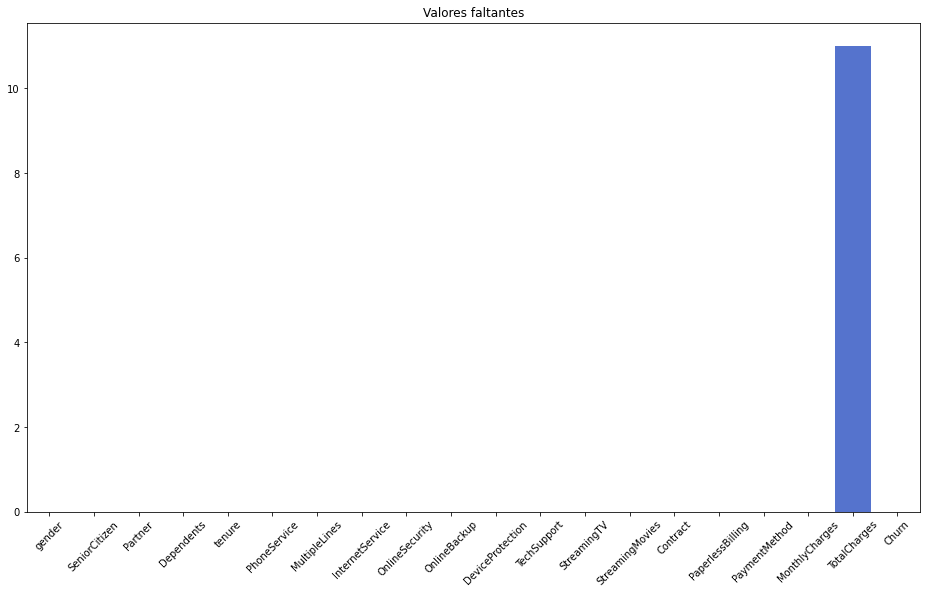

In [15]:
# Verificando se há valores faltantes
plt.figure(figsize = (16, 9))
sns.barplot(x = df.columns, y = df.isnull().sum(), palette = colors)
plt.title("Valores faltantes")
plt.xticks(rotation = 45)
plt.show();

Como podemos ver, há 11 valores faltantes na variável "TotalCharges"

# EDA (Análise Exploratória de Dados)

In [16]:
# Separando em variáveis numéricas e categóricas
numerical_features = df.nunique()[df.nunique() > 5].index
categorical_features = df.nunique()[df.nunique() <= 5].index[:-1]

Observe que defini como sendo uma variável categórica as features com um numero menor ou igual a 5 valores únicos

## Análise Univariada

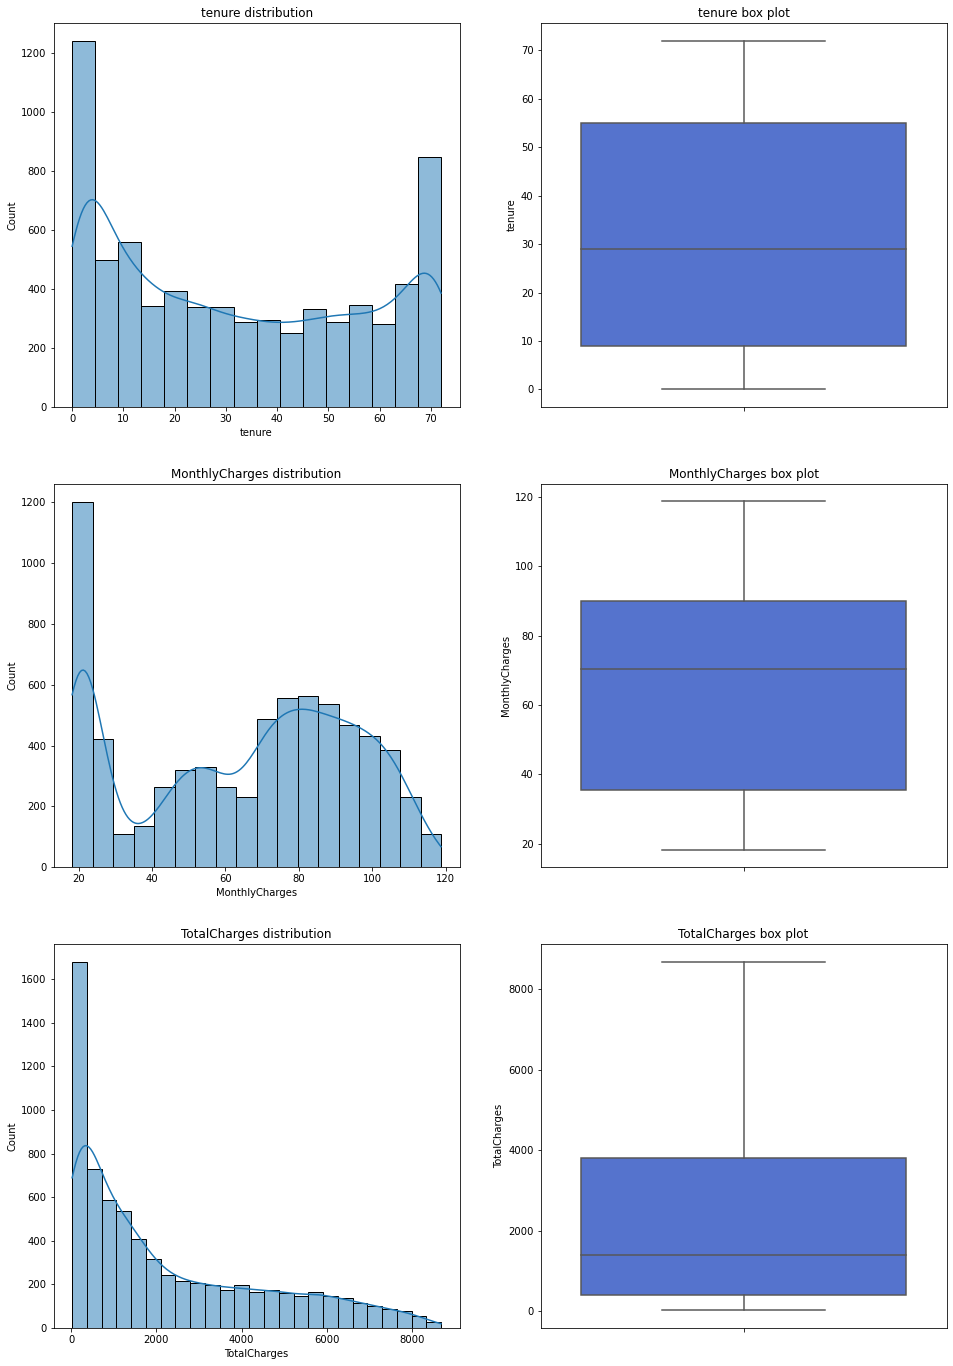

In [17]:
# Plotando gráficos da distribuição das variáveis numéricas
fig, ax = plt.subplots(3, 2, figsize = (16, 24)) 

for k in range(1, 6, 2):
    plt.subplot(3, 2, k)
    sns.histplot(data = df[numerical_features[floor(k/2)]], palette = colors, kde = True)
    title = numerical_features[floor(k/2)] + " distribution"
    plt.title(title)
    
    plt.subplot(3, 2, k+1)
    sns.boxplot(y = numerical_features[floor(k/2)], data = df, palette = colors)
    title = numerical_features[floor(k/2)] + " box plot"
    plt.title(title)

Note que a variável <strong><em>tenure</em></strong>, que indica o tempo em meses de permanência do cliente na companhia, é uma distribuição bimodal, com muitos clientes ficando menos de 5 meses e vários ficando mais de 60 meses na companhia.

Por outro lado, note que a variável Total Charges é uma distribuição bastante assimétrica positivamente. Isso significa que, a medida que o valor total de recargas vai aumentando, a quantidade de clientes que fazem um total de recargas nesse valor diminui.

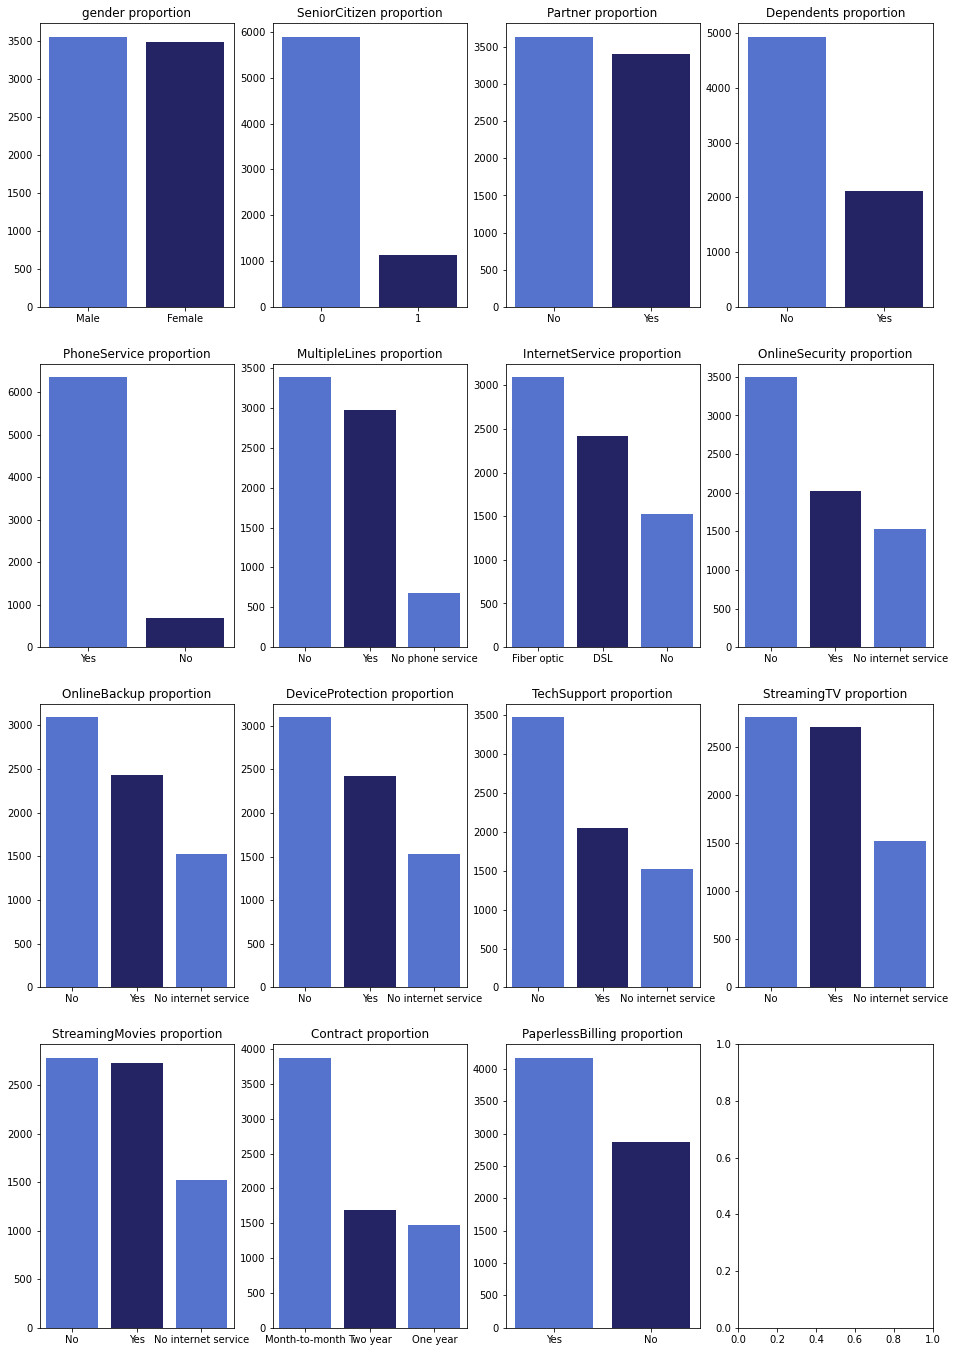

In [18]:
# Plotando gráficos com o total de observações das variáveis categóricas
fig, ax = plt.subplots(4, 4, figsize = (16, 24)) 

for k in range(len(categorical_features)-1):
    plt.subplot(4, 4, k+1)
    feature = categorical_features[k]
    sns.barplot(x = df[feature].value_counts().index, y = df[feature].value_counts().values, palette = colors)
    plt.title(feature + " proportion")
    if feature == "PaymentMethod":
        plt.xticks(rotation = 45)

Com essa análise, podemos tirar alguns insights:

**1** - A proporção de clientes homens e mulheres são praticamente equivalentes. Contudo, há muito menos pessoas idosas que não idosas.

**2** - A grande maioria possui serviço de telefone (90.31% dos clientes)

**3** - O método de pagamento mais utilizado pelos clientes é o cheque eletrônico e o tipo de contrato mais utilizado é o com renovação mensal

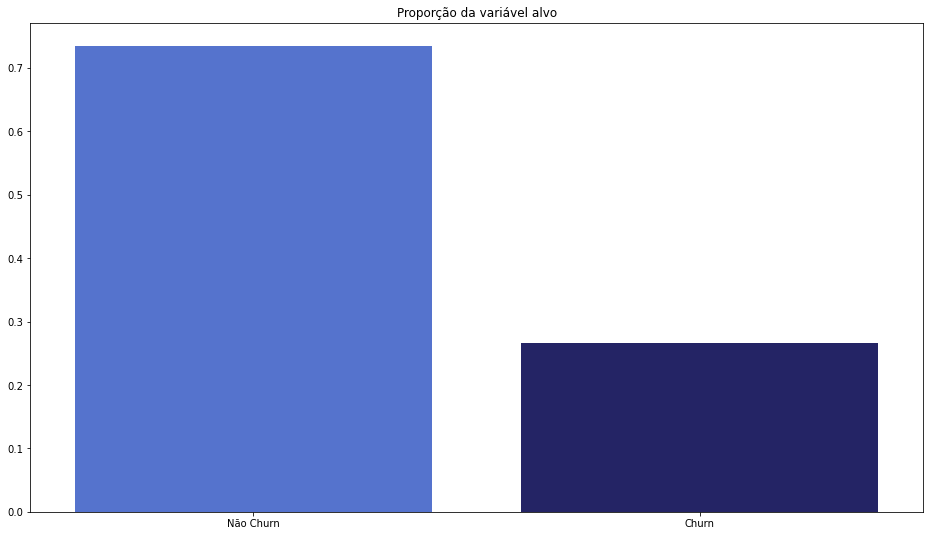

In [19]:
# Proporção da variável alvo
plt.figure(figsize = (16, 9))
sns.barplot(x = ["Não Churn", "Churn"], y = df["Churn"].value_counts(1).values, palette = colors)
plt.title("Proporção da variável alvo")
plt.show();

Como podemos ver, nosso dataset é desbalanceado. Isso faz com que o nosso modelo tenha uma tendência a aprender mais com os casos em que não há churn. Sendo assim, iremos utilizar algumas técnicas para evitar esse viés.

In [20]:
# Vendo a proporção de valores 0 e 1
value = df.Churn.value_counts()[0]/df.Churn.value_counts()[1]
print(f"A proporção é de {value:.2f}:1, aproximadamente {round(value)}:1")

A proporção é de 2.77:1, aproximadamente 3:1


## Análise bivariada

### Variáveis numéricas

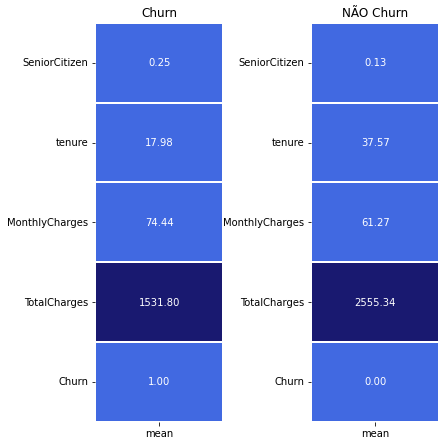

In [21]:
# Comparando features numéricas com a variável alvo
fig, ax = plt.subplots(1, 2, figsize = (6, 6))

plt.subplot(1, 2, 1)
sns.heatmap(df[df["Churn"] == 1].describe().T[["mean"]], annot = True, cmap = colors, linewidths = 0.4, linecolor = 'white', cbar = False, fmt = '.2f')
plt.title('Churn')

plt.subplot(1, 2, 2)
sns.heatmap(df[df["Churn"] == 0].describe().T[["mean"]], annot = True, cmap = colors, linewidths = 0.4, linecolor = 'white', cbar = False, fmt = '.2f')
plt.title('NÃO Churn')

fig.tight_layout(pad = 0)

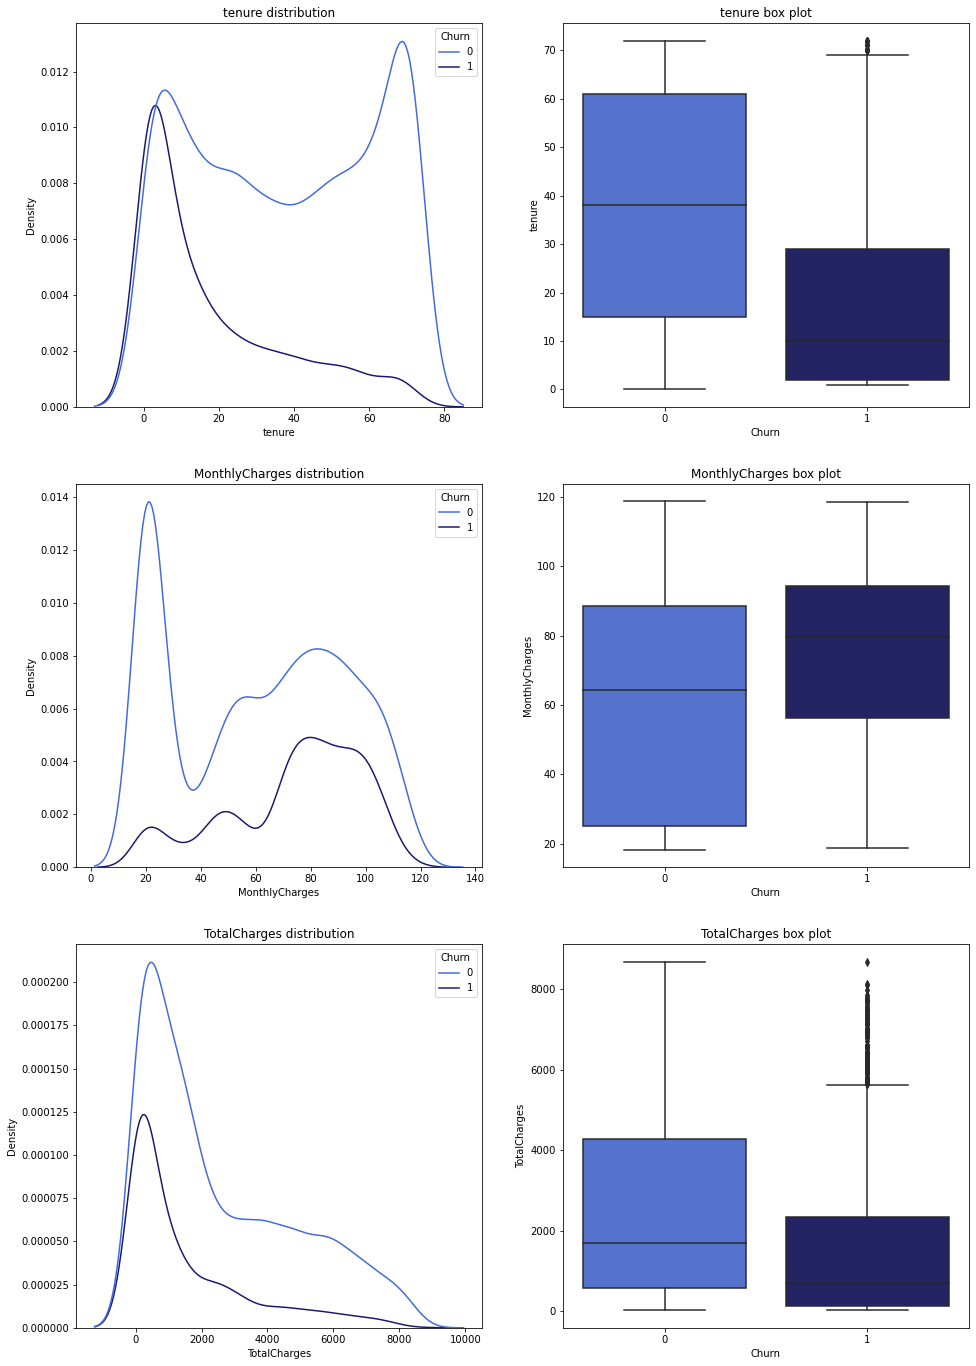

In [22]:
# Plotando gráficos da distribuição das variáveis relacionando com o Churn
fig, ax = plt.subplots(3, 2, figsize = (16, 24)) 

for k in range(1, 6, 2):
    plt.subplot(3, 2, k)
    sns.kdeplot(numerical_features[floor(k/2)], data = df, hue = "Churn", palette = colors)
    title = numerical_features[floor(k/2)] + " distribution"
    plt.title(title)
    
    plt.subplot(3, 2, k+1)
    sns.boxplot(x = "Churn", y = numerical_features[floor(k/2)], data = df, palette = colors)
    title = numerical_features[floor(k/2)] + " box plot"
    plt.title(title)

Note alguns fatos interessantes:

**1** - Clientes que deram Churn tem a recarga mensal média maior do que aqueles que não deram churn. Entretanto, a recarga total dos clientes que não deram churn é superior em mais de R$ 1.000. Isso significa que, mesmo a recarga média mensal sendo menor, eles permanecem por mais tempo sendo clientes. Dessa forma, o LTV acaba sendo maior.

**2** - A afirmação anterior que disse sobre a permanência média das pessoas que não deram churn ser maior que as que deram pode ser vista na variável tenure. Note que a média de meses que uma pessoa que não deu churn ficou é de 37 meses e 17 dias. Porém, quando olhamos a permanência média das pessoas que deram churn, esse número cai para 18 meses.

In [23]:
# Dividindo as colunas de acordo com o significado
carac_clientes = ["gender", "SeniorCitizen", "Partner", "Dependents"]
servicos = ["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
financeiro = ["Contract", "PaperlessBilling", "PaymentMethod", "MonthlyCharges", "TotalCharges"]

### Variáveis categóricas

### Analisando as características dos clientes

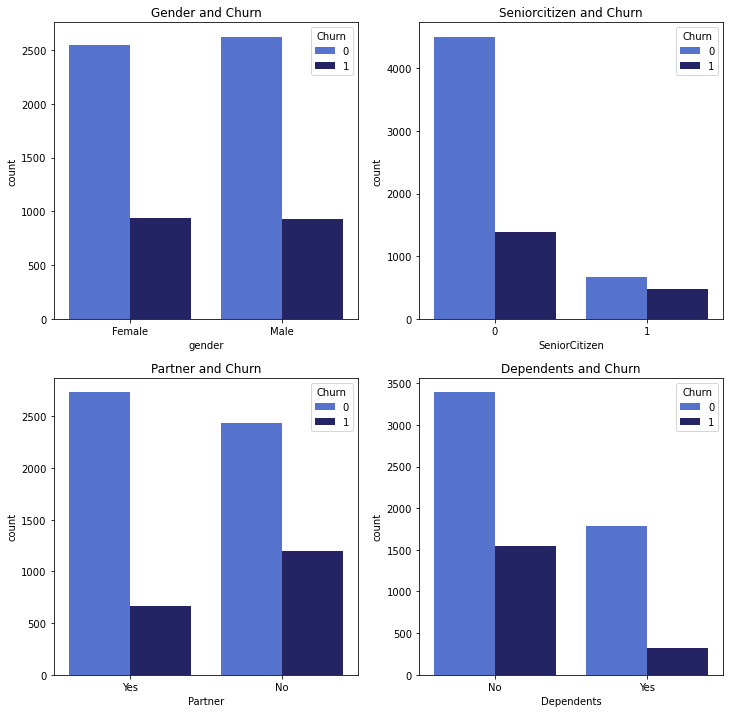

In [24]:
# Plotando as características dos clientes relacionando com o Churn
fig, ax = plt.subplots(2, 2, figsize = (12, 12))

for k in range(4):
    plt.subplot(2, 2, k+1)
    sns.countplot(carac_clientes[k], data = df, hue = 'Churn', palette = colors)
    title = carac_clientes[k].capitalize() + " and Churn"
    plt.title(title)

Vamos analisar esses gráficos:

**1** - Note que a proporção de homens e mulheres que dão churn é bem próxima (~26% de churn para ambos).

**2** - Entretanto, quando olhamos a proporção de churn quando a pessoa é idosa, temos uma relação diferente da anterior. Quando estamos lidando com alguém não idoso, a proporção de churn é baixa, sendo aproximadamente 24%. Entretanto, quando lidamos com pessoas idosas, essa porcentagem aumenta para 42%.

**3** - Além disso, pessoas sem parceiro e sem dependentes possuem uma taxa de churn maior que pessoas com algum tipo de parceiro e com dependentes, respectivamente.

### Analisando os serviços oferecidos pela companhia

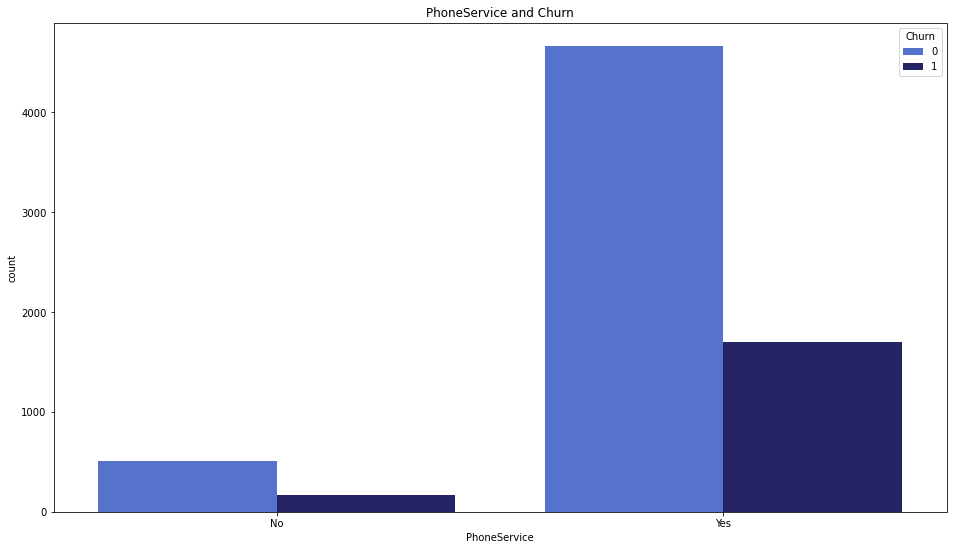

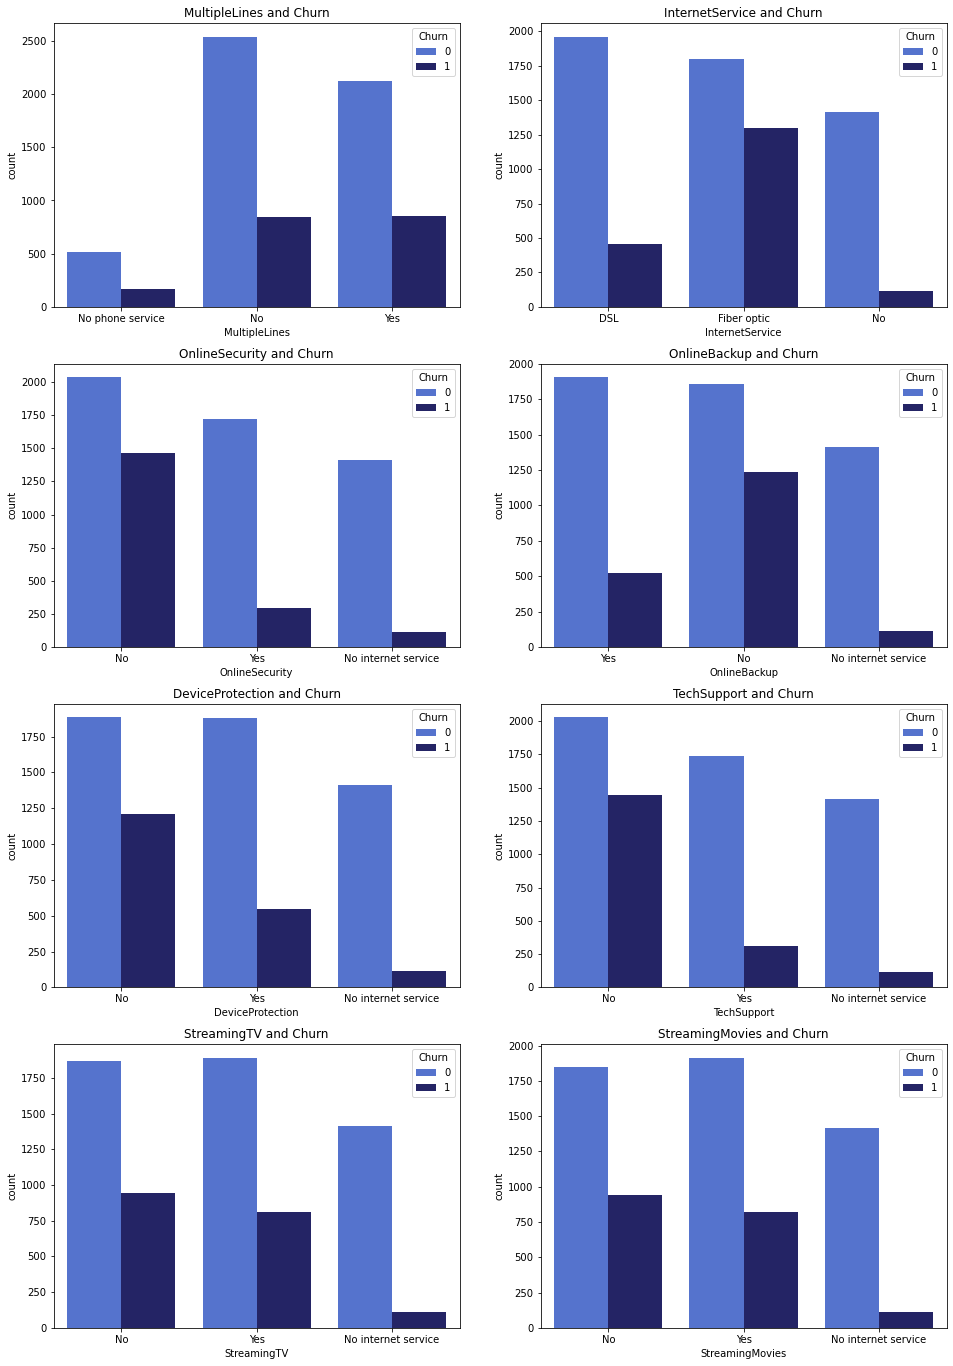

In [25]:
# Plotando os serviços oferecidos pela companhia relacionando com o Churn
fig, aux = plt.subplots(1, 1, figsize = (16, 9))
sns.countplot(x = servicos[0], data = df, hue = "Churn", palette = colors)
title = servicos[0] + " and Churn"
plt.title(title);

fig, aux = plt.subplots(4, 2, figsize = (16, 24))

for i in range(8):
    plt.subplot(4, 2, i+1)
    sns.countplot(x = servicos[i+1], data = df, hue = "Churn", palette = colors)
    title = servicos[i+1] + " and Churn"
    plt.title(title);

Analisando os gráficos e os percentuais, podemos fazer algumas conclusões:

**1** - Pessoas que possuem ou não serviço de celular possuem taxas de churn parecidas.

**2** - Pessoas que possuem fibra óptica como serviço de internet possuem alto índice de churn (~42%). Talvez, seja devido à insatisfação com o produto. Seria bom contatar a equipe técnica responsável pela fibra óptica para analisar o desempenho.

**3** - Agora, para aqueles que possuem o serviço de internet, temos alguns outros serviços que, quando não são adquiridos pelo cliente, geram um alto índice de churn: segurança online, backup, proteção do dispositivo e assistência técnica. O índice de churn dos quatro serviços, quando não adquiridos pelo cliente - não necessariamente os 4 juntos -, é de aproximadamente 40%.

### Analisando as informações do setor financeiro da companhia

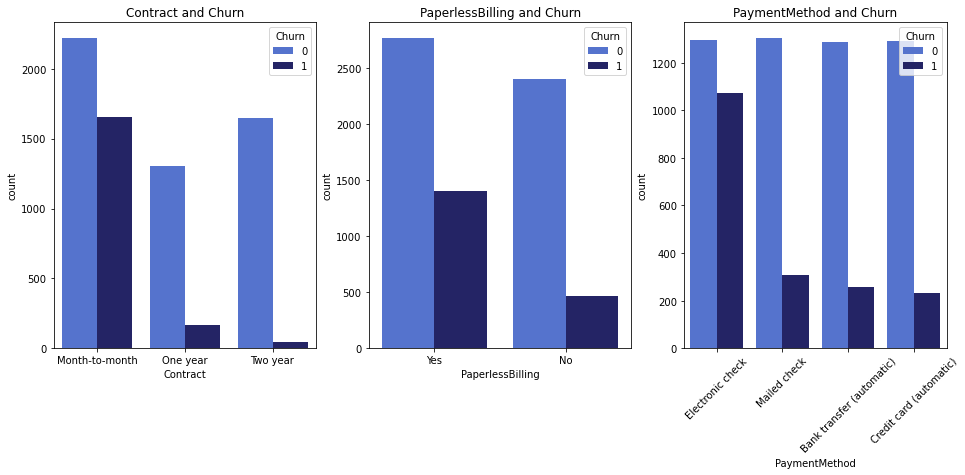

In [26]:
# Plotando as variáveis do setor financeiro relacionando com o Churn
fig, ax = plt.subplots(1, 3, figsize = (16, 6))

for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.countplot(x = financeiro[i], data = df, hue = "Churn", palette = colors)
    title = financeiro[i] + " and Churn"
    plt.title(title);
    if financeiro[i] == "PaymentMethod":
        plt.xticks(rotation = 45)

Note alguns pontos interessantes:

**1** - Pessoas que possuem o contrato renovado de mês em mês possuem um índice de churn muito maior do que aqueles que o contrato é renovado a cada 1 ou 2 anos.

**2** - Clientes que utilizam o cheque eletrônico como forma de pagamento possuem um índice de churn muito maior quando comparado aos outros. É importante ficar de olho nisso. Talvez, retirar este método de pagamento pode ajudar as companhias.

# Modelagem

In [27]:
# Separando as variáveis preditivas da variável alvo
X = df.drop(columns = ["Churn"], axis = 1)
y = df["Churn"]

In [28]:
# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [29]:
# Copiando os datasets originais
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [30]:
# Separando em variáveis categóricas binárias e não binárias
categorical_features_binary = X.nunique()[X.nunique() == 2].index
categorical_features_non_binary = X.nunique()[(X.nunique() > 2) & (X.nunique() <= 5)].index

In [31]:
# Criando um transformador para preencher valores faltantes
missing_transformer = ColumnTransformer([
    ('num_missing', SimpleImputer(strategy = 'median'), numerical_features),
    ('cat_missing', SimpleImputer(strategy = 'most_frequent'), categorical_features)
])

In [32]:
# Criano um transformador para codificar variáveis categóricas
cat_transformer = ColumnTransformer([
    ('cat_binary', OneHotEncoder(drop = 'first'), categorical_features_binary),
    ('cat_non_binary', ce.TargetEncoder(), categorical_features_non_binary)
]) 

In [33]:
# Fazendo o pré processamento
X_train, X_test = preprocessor(X_train, y_train, X_test, MinMaxScaler())

## Testando modelos

### XGBoost Classifier

In [34]:
# Criação do modelo
xgb = XGBClassifier(n_estimators = 1000, max_depth = 5, random_state = 0, scale_pos_weight = 2.77)

In [35]:
# Avaliação do desempenho
modelo(xgb, X_train, y_train, X_test, y_test)

Score Cross Validation: 80.69%
Average Precision: 43.97%
Precision Score: 56.60%
Recall Score: 58.32%
F1 Score: 57.45%
ROC AUC Score: 71.18%


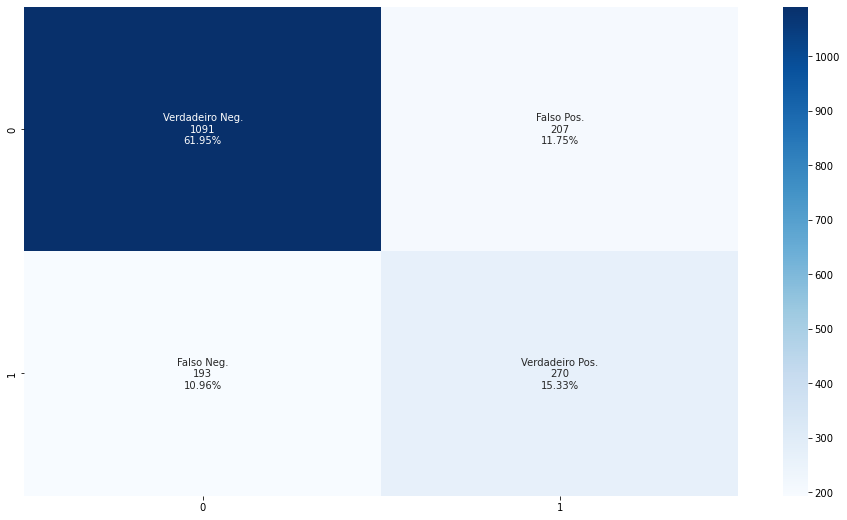

In [36]:
# Vendo a matriz de confusão
matriz_confusao(xgb, X_test, y_test)

### Light GBM Classifier

In [37]:
# Criação do modelo
lgbm = LGBMClassifier(n_estimators = 1000, max_depth = 5, random_state = 0, scale_pos_weight = 2.77)

In [38]:
# Avaliação do desempenho
modelo(lgbm, X_train, y_train, X_test, y_test)

Score Cross Validation: 81.77%
Average Precision: 43.55%
Precision Score: 54.53%
Recall Score: 61.12%
F1 Score: 57.64%
ROC AUC Score: 71.47%


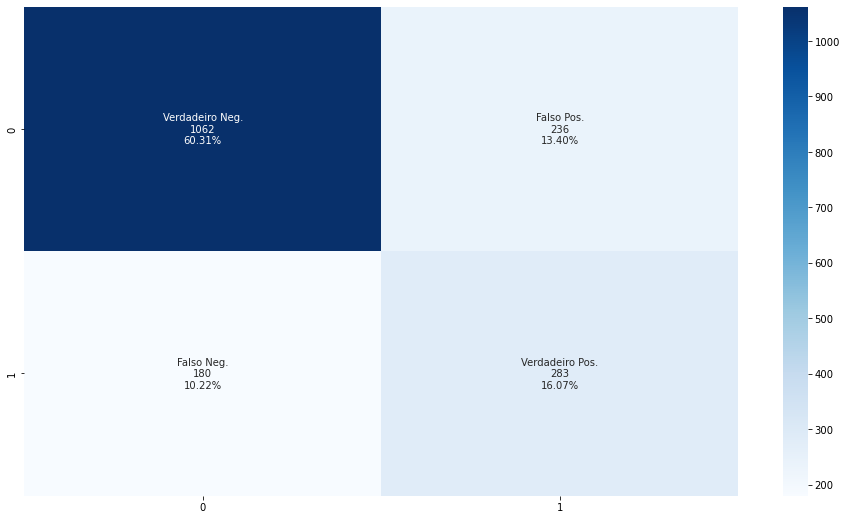

In [39]:
# Vendo a matriz de confusão
matriz_confusao(lgbm, X_test, y_test)

### Random Forest Classifier

In [40]:
# Criação do modelo
rfc = RandomForestClassifier(n_estimators = 1000, max_depth = 7, random_state = 0, n_jobs = -1, class_weight = 'balanced')

In [41]:
# Avaliação do desempenho
modelo(rfc, X_train, y_train, X_test, y_test)

Score Cross Validation: 85.15%
Average Precision: 45.55%
Precision Score: 51.69%
Recall Score: 75.81%
F1 Score: 61.47%
ROC AUC Score: 75.27%


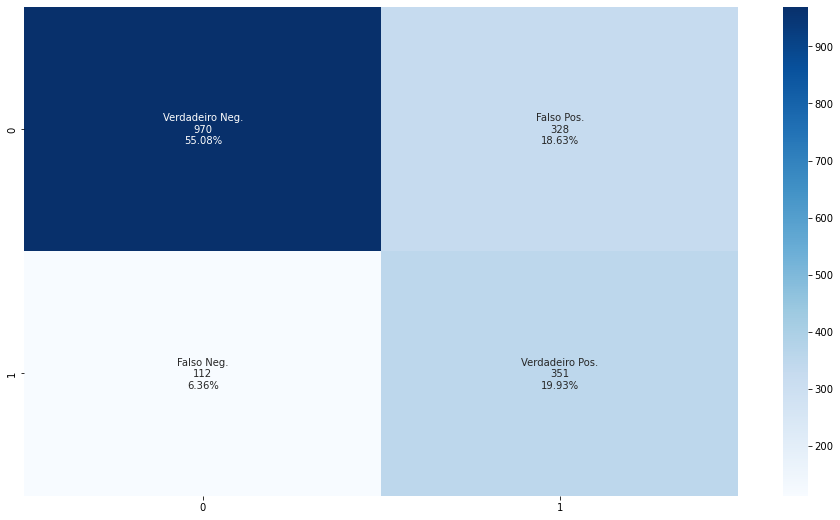

In [42]:
# Vendo a matriz de confusão
matriz_confusao(rfc, X_test, y_test)

### CatBoost Classifier

In [43]:
# Criação do modelo
cbc = CatBoostClassifier(n_estimators = 1000, max_depth = 5, random_state = 0, class_weights = {0: 1, 1: 2.77}, verbose = False)

In [44]:
# Avaliação do desempenho
modelo(cbc, X_train, y_train, X_test, y_test)

Score Cross Validation: 84.80%
Average Precision: 45.96%
Precision Score: 52.23%
Recall Score: 75.81%
F1 Score: 61.85%
ROC AUC Score: 75.54%


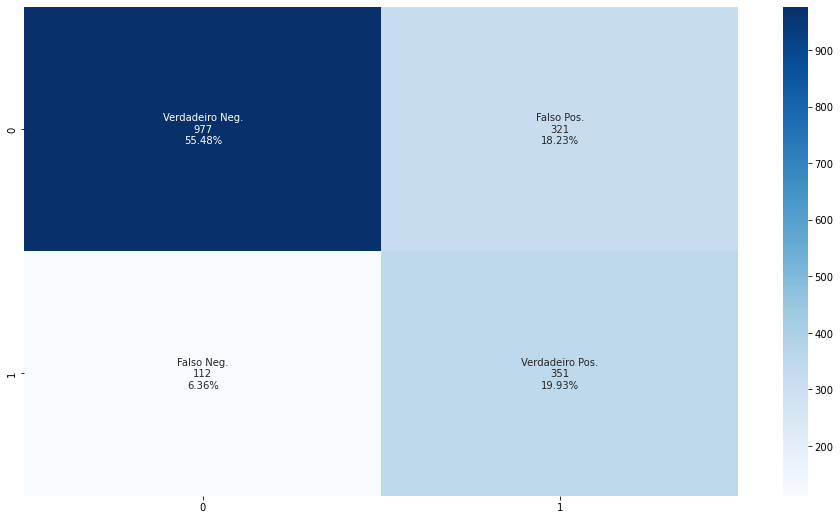

In [45]:
# Vendo a matriz de confusão
matriz_confusao(cbc, X_test, y_test)

Como podemos ver, o modelo que melhor perfomou foi o CatBoost. Sendo assim, vamos fazer uma tunagem de hiperparâmetros e, depois, a análise do custo-benefício do modelo.

## Tunagem de Hiperparâmetros - Bayesian Search

In [46]:
# Criando o espaço de navegação dos hiperparâmetros
space = [(1e-3, 1e-1, 'log-uniform'),    # learning_rate
         (1, 100),                       # min_child_samples
         (0.05, 1.0),                    # subsample
         (2, 16)]                        # max_depth

resultado = gp_minimize(treinar_modelo, space, random_state = 1, verbose = False, n_calls = 30, n_random_starts = 10)

In [47]:
# Visualizando os hiperparâmetros encontrados
resultado.x

[0.021083165645791862, 100, 1.0, 3]

In [48]:
# Construindo o modelo final
model = CatBoostClassifier(learning_rate = 0.02108, max_depth = 3, 
                               min_child_samples = 100, subsample = 1, 
                               n_estimators = 1000, class_weights = {0: 1, 1: 2.77}, random_state = 0, verbose = False)

In [49]:
# Testando o modelo
modelo(model, X_train, y_train, X_test, y_test)

Score Cross Validation: 85.03%
Average Precision: 46.34%
Precision Score: 51.86%
Recall Score: 78.40%
F1 Score: 62.42%
ROC AUC Score: 76.22%


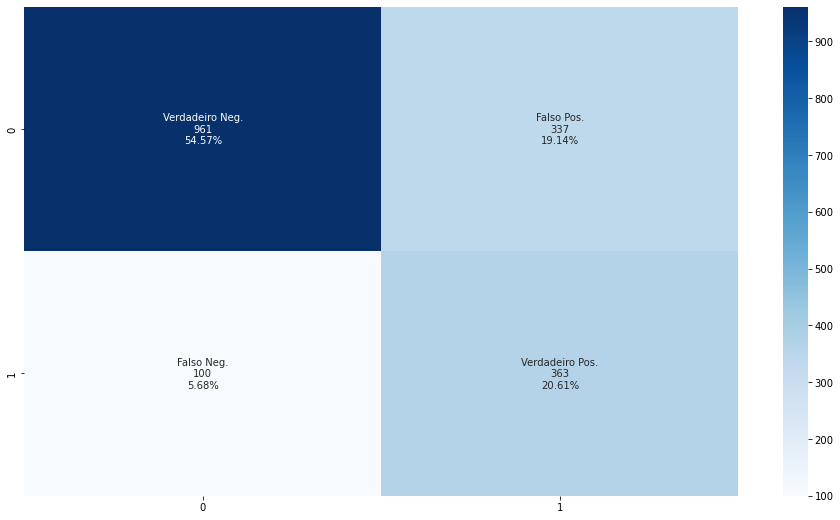

In [50]:
# Vendo a matriz de confusão
matriz_confusao(model, X_test, y_test)

# Análise de negócio

Para recapitular, lembre-se da performance do CatBoost:

- Score Cross Validation: 85.03%
- Average Precision: 46.34%
- Precision Score: 51.86%
- Recall Score: 78.40%
- F1 Score: 62.42%
- ROC AUC Score: 76.22%

Olhando para o Recall, vemos que de todas as pessoas que realmente deram churn, nosso modelo conseguiu acertar 78.4% dos casos. Entretanto, nosso modelo acertou apenas 51.86% dos casos em que ele disse que era churn.

Para analisar o custo-benefício, a solução que nós iremos utilizar para reter o cliente por mais algum tempo é: <hr><center>**"Ganhe um desconto de 30% na sua recarga mensal nos próximos 6 meses!"**</center><hr>

Vamos dizer que essa promoção consiga reter os clientes que dariam churn por mais 6 meses. 

Dessa forma, vamos calcular quanto estamos ganhando com a permanência dos clientes que dariam churn e quanto estamos deixando de ganhar aplicando a promoção para pessoas que não dariam churn, mas que o nosso modelo previu que dariam.

O primeiro passo é selecionar o dataframe contendo as pessoas que o nosso modelo previu que dariam churn

In [58]:
# Dataset com Previsão = Churn e Real = Churn
y_pred = pd.Series(model.predict(X_test))
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)["Churn"] == y_pred]
indexes_1 = intersec[intersec == 1].index
X_test_copy_1 = X_test_copy.reset_index().drop(columns = 'index', axis = 1).iloc[indexes_1, :]
X_test_copy_1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5,Male,1,No,No,3,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,79.90,260.90
7,Female,1,Yes,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.55,69.55
15,Male,0,No,No,2,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,44.35,81.25
28,Female,0,No,No,3,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,97.90,315.30
31,Male,0,No,No,2,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,45.35,89.50


Agora, vamos aplicar 30% de desconto no MonthlyCharges e multiplicar por 6. Dessa forma, vamos saber o valor que ganhamos com a permanência do cliente

In [59]:
# Valor recebido com a permanência
valor_total = (X_test_copy_1["MonthlyCharges"].values*0.7*6).sum()
print(f"O valor total recebido com a permanência dos clientes que dariam churn será: R$ {valor_total:.2f}")

O valor total recebido com a permanência dos clientes que dariam churn será: R$ 116489.31


Agora, vamos ver quanto perdemos devido à saída de um cliente que daria churn, mas nosso modelo não previu. 

Novamente, vamos utilizar o cálculo com os 30% de desconto e retenção de 6 meses porque caso tivéssemos acertado que eles iriam sair, poderíamos oferecer a promoção e, como fizemos a suposição, ele ficaria mais 6 meses pagando 30% da recarga mensal média.

In [60]:
# Dataset com Previsão = Não Churn e Real = Churn 
y_pred = pd.Series(model.predict(X_test))
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)["Churn"] != y_pred]
indexes_2 = intersec[intersec == 0].index
X_test_copy_2 = X_test_copy.reset_index().drop(columns = 'index', axis = 1).iloc[indexes_2, :]
X_test_copy_2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
21,Female,0,Yes,Yes,35,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Month-to-month,No,Electronic check,72.25,2568.55
27,Male,0,No,No,7,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,51.00,354.05
37,Male,0,No,No,5,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,43.25,219.00
63,Female,0,Yes,Yes,43,Yes,No,DSL,No,No,No,No,Yes,No,Month-to-month,No,Electronic check,56.15,2499.30
67,Female,0,Yes,Yes,70,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),114.20,7723.90


In [61]:
# Valor perdido com a saída do cliente
valor_total = (X_test_copy_2["MonthlyCharges"].values*0.7*6).sum()
print(f"O valor total perdido com a saída dos clientes que deram churn e nosso modelo não previu será: R$ {valor_total:.2f}")

O valor total perdido com a saída dos clientes que deram churn e nosso modelo não previu será: R$ 28658.91


Agora, vamos calcular quanto deixamos de ganhar com a oferta do desconto a uma pessoa que pagaria normalmente 100% do valor da recarga

In [62]:
# Dataset com Previsão = Churn e Real = Não churn
y_pred = pd.Series(model.predict(X_test))
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)["Churn"] != y_pred]
indexes_3 = intersec[intersec == 1].index
X_test_copy_3 = X_test_copy.reset_index().drop(columns = 'index', axis = 1).iloc[indexes_3, :]
X_test_copy_3.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2,Female,0,No,No,13,Yes,No,DSL,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,71.95,923.85
9,Male,1,Yes,No,35,Yes,Yes,Fiber optic,Yes,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check,94.55,3365.40
11,Male,1,Yes,No,29,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,51.60,1442.00
13,Male,0,No,Yes,2,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.30,108.65
19,Male,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.80,146.65


In [63]:
# Valor deixado de ganhar com a oferta da promoção ao cliente que não daria churn
valor_total = (X_test_copy_2["MonthlyCharges"].values*0.3*6).sum()
print(f"O valor total deixado de ganhar com a oferta da promoção a clientes que não dariam churn será: R$ {valor_total:.2f}")

O valor total deixado de ganhar com a oferta da promoção a clientes que não dariam churn será: R$ 12282.39


## Resultado

Como vimos, ganharíamos um total de **R$ 116489.31** com a permanência dos clientes que dariam churn e nosso modelo conseguiu prever. 

Porém, iríamos perder **R$ 40941.30** (28658.91 + 12282.39) com os erros do nosso modelo.

Sendo assim teríamos um **LUCRO** de **R$ 75548.01**.

Aqui, estou desconsiderando o custo computacional para rodar o modelo. Porém, em termos práticos, o resultado seria este.

Parece uma boa solução, não? Porém, sempre há espaço para melhorias no modelo e, consequentemente, aumento no lucro.

### Obs.:

Se aumentássemos o desconto de 30 para 50%, o lucro seria de **R$ 42265.35**. 

Além disso, o ponto de equilíbrio seria um desconto de, aproximadamente, **75.39%** no valor da recarga mensal.

Para concluir, se utilizássemos a Random Forest no lugar do Catboost, teríamos um lucro de **R$ 64604.93**, ou seja, quase 11k a menos! Por isso, é sempre importante tentar melhorar o modelo em produção.